In [1]:
import sys
sys.path.append("./src")
from src.make_dataset import make_dataset


/home/babaid/miniconda3/envs/bio/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
To use the Graphein submodule graphein.protein.features.sequence.embeddings, you need to install: biovec 
biovec cannot be installed via conda
To use the Graphein submodule graphein.protein.visualisation, you need to install: pytorch3d 
To do so, use the following command: conda install -c pytorch3d pytorch3d


In [2]:
import sys
sys.path.append("./src")
from src.model import ProBindNN

In [8]:
model = ProBindNN().to("cuda")

In [9]:
from torch_geometric.loader import DataLoader
from torch import nn
device = "cuda" if torch.cuda.is_available() else "cpu"
dataset = MutationDataset(index_xlsx="index.xlsx", root="datasetmf")
train_size = int(len(dataset)*0.81)#0.8042)
val_size = int(0.5*(len(dataset)-train_size))
train_dataset, val_dataset, test = torch.utils.data.random_split(dataset, [train_size, val_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=True)

In [10]:
len(val_dataset)

470

In [11]:
from torch.optim.lr_scheduler import ExponentialLR
optimizer = torch.optim.Adam(model.parameters())
scheduler = scheduler = ExponentialLR(optimizer, gamma=0.9)
loss_fn =  nn.MSELoss()

In [16]:
import copy
from tqdm import tqdm
from IPython.display import clear_output

epochs = 500
model.train()
writer = SummaryWriter("tensorboard_runs")
for epoch in tqdm(range(1, epochs)):
    epoch_loss = 0.
    best_loss = 1000.
    model.train()
    for i, batch in enumerate(train_loader) :
        x, y = batch["mutated"].to(device), batch["non_mutated"].to(device)
        ddg = x.ddg.to(device).squeeze()
        optimizer.zero_grad()
        out = model(x, y).squeeze()
        loss = loss_fn(out, ddg)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        clear_output(wait=True)
        
    epoch_loss/=len(train_loader)
    writer.add_scalar("Loss/train", epoch_loss, epoch)
    print("Epoch: {}, Loss: {}".format(epoch, epoch_loss))
    
    
    model.eval()
    val_loss = 0

    for i, batch in enumerate(val_loader):
        x, y = batch["mutated"].to(device), batch["non_mutated"].to(device)
        ddg = x.ddg.to(device).squeeze()
        out = model(x, y).squeeze()
        loss = loss_fn(out, ddg)
        val_loss+=loss.item()
    val_loss /= len(val_loader) 
    writer.add_scalar("Loss/val", val_loss, epoch)
    
    print("Validation loss:", val_loss)
    
    
    if epoch_loss<best_loss:
        best_model = copy.deepcopy(model)
        
        torch.save(model.state_dict(), "model_prob.pt")
    else:
        
        scheduler.step()


Epoch: 1, Loss: 1.5772616937756538


  0%|          | 1/499 [00:24<3:22:40, 24.42s/it]

Validation loss: 1.7520055770874023


In [11]:
model.load_state_dict(torch.load("model_bind.pt"))

<All keys matched successfully>

100%|██████████| 470/470 [00:17<00:00, 27.49it/s]


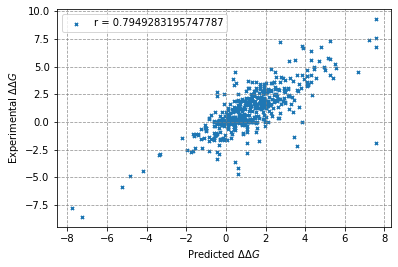

In [15]:
from src.visualize import comparator
model.load_state_dict(torch.load("model_binder.pt"))
comparator(model, val_dataset, len(val_dataset), "validation3.csv", "cuda")

In [21]:
mean, var = 0 , 0
ddgs = torch.tensor([i["mutated"].ddg for i in dataset])
mean = torch.mean(ddgs)
var = torch.var(ddgs)
print("Mean: {}, Variance: {}".format(mean, var))

Mean: 1.1391819715499878, Variance: 4.132085800170898
